# Step 1. Data Extraction

In [71]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.preprocessing import LabelEncoder, StandardScaler
from mpl_toolkits.mplot3d import Axes3D 
import warnings
warnings.filterwarnings("ignore")

In [2]:
# creating the sqlalchemy engine

engine = create_engine('mssql+pyodbc://PRECIOUS\DONSQLEXPRESS/AdventureWorks2019?driver=SQL+Server')
engineDW = create_engine('mssql+pyodbc://PRECIOUS\DONSQLEXPRESS/AdventureWorksDW2019?driver=SQL+Server')

In [3]:
# Sales Order Header table

sales_header = """SELECT
    SC.[CustomerID],
    PP.ProductID,
    PC.[Name] AS [Product Category],
    PS.[Name] AS [Product Subcategory],
    SH.[SalesOrderID],
    SS.OrderQty
FROM [Sales].[SalesOrderHeader] SH
LEFT JOIN [Sales].[Customer] SC ON SH.CustomerID = SC.[CustomerID]
LEFT JOIN [Sales].[SalesOrderDetail] SS ON SS.SalesOrderID = SH.SalesOrderID
LEFT JOIN [Production].[Product] PP ON PP.ProductID = SS.ProductID
LEFT JOIN [Production].[ProductSubcategory] PS ON PS.[ProductSubcategoryID] = PP.ProductSubcategoryID
LEFT JOIN [Production].[ProductCategory] PC ON PC.[ProductCategoryID] = PS.ProductCategoryID;
"""

with engine.connect() as conn:
    sh = pd.read_sql(sales_header, conn)
sh.columns

Index(['CustomerID', 'ProductID', 'Product Category', 'Product Subcategory',
       'SalesOrderID', 'OrderQty'],
      dtype='object')

In [4]:
sh.head()

,CustomerID,ProductID,Product Category,Product Subcategory,SalesOrderID,OrderQty
0,29825,776,Bikes,Mountain Bikes,43659,1
1,29825,777,Bikes,Mountain Bikes,43659,3
2,29825,778,Bikes,Mountain Bikes,43659,1
3,29825,771,Bikes,Mountain Bikes,43659,1
4,29825,772,Bikes,Mountain Bikes,43659,1


In [5]:
# Sales Order Detail table

sales_order = """select soh.customerID,
soh.OrderDate,
soh.ShipDate,
sod.UnitPrice, 
soh.TotalDue, 
sod.LineTotal, 
st.Name as region from Sales.SalesOrderDetail as sod
join Sales.SalesOrderHeader as soh 
on sod.SalesOrderID=soh.SalesOrderID
join Production.Product as p
on sod.ProductID=p.ProductID
INNER JOIN Sales.SalesTerritory AS St
    ON Soh.[TerritoryID] = St.[TerritoryID]
"""

with engine.connect() as conn:
    sd = pd.read_sql(sales_order, engine)
sd.columns

Index(['customerID', 'OrderDate', 'ShipDate', 'UnitPrice', 'TotalDue',
       'LineTotal', 'region'],
      dtype='object')

In [6]:
sd.head()

,customerID,OrderDate,ShipDate,UnitPrice,TotalDue,LineTotal,region
0,29825,2011-05-31,2011-06-07,2024.994,23153.2339,2024.994,Southeast
1,29825,2011-05-31,2011-06-07,2024.994,23153.2339,6074.982,Southeast
2,29825,2011-05-31,2011-06-07,2024.994,23153.2339,2024.994,Southeast
3,29825,2011-05-31,2011-06-07,2039.994,23153.2339,2039.994,Southeast
4,29825,2011-05-31,2011-06-07,2039.994,23153.2339,2039.994,Southeast


In [7]:
# Customer's Information 

customer_info = """SELECT  [BirthDate],
[MaritalStatus],
[YearlyIncome],
[Gender],[NumberChildrenAtHome], dg.PostalCode, 
dc.[TotalChildren],
[EnglishEducation],[EnglishOccupation],
[HouseOwnerFlag],[CustomerKey],
[NumberCarsOwned] 
FROM [dbo].[DimCustomer] as dc
Join [dbo].[DimGeography] as dg
on dc.[GeographyKey] = dg.GeographyKey
"""

with engineDW.connect() as conn:
    cust = pd.read_sql(customer_info, conn)
cust.columns

Index(['BirthDate', 'MaritalStatus', 'YearlyIncome', 'Gender',
       'NumberChildrenAtHome', 'PostalCode', 'TotalChildren',
       'EnglishEducation', 'EnglishOccupation', 'HouseOwnerFlag',
       'CustomerKey', 'NumberCarsOwned'],
      dtype='object')

In [8]:
# Merge the different tables (sh, sd, cust) to form one DataFrame

sd.rename(columns={"customerID" : "CustomerID"}, inplace=True)
cust.rename(columns={"CustomerKey" : "CustomerID"}, inplace=True)

df = pd.merge(sh, sd, on='CustomerID', how='inner').merge(cust, on='CustomerID', how='inner')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324320 entries, 0 to 324319
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   CustomerID            324320 non-null  int64         
 1   ProductID             324320 non-null  int64         
 2   Product Category      324320 non-null  object        
 3   Product Subcategory   324320 non-null  object        
 4   SalesOrderID          324320 non-null  int64         
 5   OrderQty              324320 non-null  int64         
 6   OrderDate             324320 non-null  datetime64[ns]
 7   ShipDate              324320 non-null  datetime64[ns]
 8   UnitPrice             324320 non-null  float64       
 9   TotalDue              324320 non-null  float64       
 10  LineTotal             324320 non-null  float64       
 11  region                324320 non-null  object        
 12  BirthDate             324320 non-null  object        
 13 

# Step 2: Data Exploration and Data Wrangling

## Data Exploration 

In [9]:
# Get the number of rows, columns, datatypes and missing data

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324320 entries, 0 to 324319
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   CustomerID            324320 non-null  int64         
 1   ProductID             324320 non-null  int64         
 2   Product Category      324320 non-null  object        
 3   Product Subcategory   324320 non-null  object        
 4   SalesOrderID          324320 non-null  int64         
 5   OrderQty              324320 non-null  int64         
 6   OrderDate             324320 non-null  datetime64[ns]
 7   ShipDate              324320 non-null  datetime64[ns]
 8   UnitPrice             324320 non-null  float64       
 9   TotalDue              324320 non-null  float64       
 10  LineTotal             324320 non-null  float64       
 11  region                324320 non-null  object        
 12  BirthDate             324320 non-null  object        
 13 

In [10]:
# Statistical visualisation of the numerical variables

df.describe().round(1)

,CustomerID,ProductID,SalesOrderID,OrderQty,UnitPrice,TotalDue,LineTotal,YearlyIncome,NumberChildrenAtHome,TotalChildren,NumberCarsOwned
count,324320.0,324320.0,324320.0,324320.0,324320.0,324320.0,324320.0,324320.0,324320.0,324320.0,324320.0
mean,16182.0,854.6,62060.0,1.0,389.0,958.6,389.0,63724.7,1.3,2.0,1.5
std,5281.5,83.4,7788.1,0.0,851.7,1160.1,851.7,31588.4,1.7,1.7,1.1
min,11000.0,707.0,43697.0,1.0,2.3,2.5,2.3,10000.0,0.0,0.0,0.0
25%,11530.0,783.0,55815.0,1.0,5.0,55.2,5.0,40000.0,0.0,0.0,1.0
50%,14253.0,873.0,62232.5,1.0,25.0,136.4,25.0,60000.0,0.0,2.0,2.0
75%,19623.0,922.0,68630.0,1.0,54.0,2288.9,54.0,80000.0,3.0,4.0,2.0
max,29483.0,999.0,75123.0,1.0,3578.3,3954.0,3578.3,170000.0,5.0,5.0,4.0


## Data Wrangling

In [11]:
# rename columns 

df.rename(columns={'EnglishEducation':'Education','EnglishOccupation':'Occupation'},inplace=True)
df.columns

Index(['CustomerID', 'ProductID', 'Product Category', 'Product Subcategory',
       'SalesOrderID', 'OrderQty', 'OrderDate', 'ShipDate', 'UnitPrice',
       'TotalDue', 'LineTotal', 'region', 'BirthDate', 'MaritalStatus',
       'YearlyIncome', 'Gender', 'NumberChildrenAtHome', 'PostalCode',
       'TotalChildren', 'Education', 'Occupation', 'HouseOwnerFlag',
       'NumberCarsOwned'],
      dtype='object')

In [12]:
# Converting all the ID's from numerical values to categorical values

for column in df.columns:
    if column.endswith('ID'):
        df[column] = df[column].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324320 entries, 0 to 324319
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   CustomerID            324320 non-null  category      
 1   ProductID             324320 non-null  category      
 2   Product Category      324320 non-null  object        
 3   Product Subcategory   324320 non-null  object        
 4   SalesOrderID          324320 non-null  category      
 5   OrderQty              324320 non-null  int64         
 6   OrderDate             324320 non-null  datetime64[ns]
 7   ShipDate              324320 non-null  datetime64[ns]
 8   UnitPrice             324320 non-null  float64       
 9   TotalDue              324320 non-null  float64       
 10  LineTotal             324320 non-null  float64       
 11  region                324320 non-null  object        
 12  BirthDate             324320 non-null  object        
 13 

In [13]:
# convert Birthdate to datatime and create age from it 

df['BirthDate'] = pd.to_datetime(df['BirthDate'])

df['Age'] = (df['OrderDate'] - df['BirthDate']).dt.days // 365

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324320 entries, 0 to 324319
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   CustomerID            324320 non-null  category      
 1   ProductID             324320 non-null  category      
 2   Product Category      324320 non-null  object        
 3   Product Subcategory   324320 non-null  object        
 4   SalesOrderID          324320 non-null  category      
 5   OrderQty              324320 non-null  int64         
 6   OrderDate             324320 non-null  datetime64[ns]
 7   ShipDate              324320 non-null  datetime64[ns]
 8   UnitPrice             324320 non-null  float64       
 9   TotalDue              324320 non-null  float64       
 10  LineTotal             324320 non-null  float64       
 11  region                324320 non-null  object        
 12  BirthDate             324320 non-null  datetime64[ns]
 13 

### Calculating the RFM Score (Recency, Frequency, Monetary)

In [14]:
# Step 1: Create the Total Price

data = df[['CustomerID', 'SalesOrderID', 'OrderQty', 'OrderDate', 'UnitPrice', ]]

data.head()

,CustomerID,SalesOrderID,OrderQty,OrderDate,UnitPrice
0,21768,43697,1,2011-05-31,3578.27
1,21768,43697,1,2013-09-14,539.99
2,21768,56212,1,2011-05-31,3578.27
3,21768,56212,1,2013-09-14,539.99
4,28389,43698,1,2011-05-31,3399.99


In [15]:
# Creating the Total Price column using the order quantity and unit price

data['TotalPrice'] = data.loc[:, 'OrderQty'] * df.loc[:, 'UnitPrice']

data.head()

,CustomerID,SalesOrderID,OrderQty,OrderDate,UnitPrice,TotalPrice
0,21768,43697,1,2011-05-31,3578.27,3578.27
1,21768,43697,1,2013-09-14,539.99,539.99
2,21768,56212,1,2011-05-31,3578.27,3578.27
3,21768,56212,1,2013-09-14,539.99,539.99
4,28389,43698,1,2011-05-31,3399.99,3399.99


In [16]:
# Creating the customer churn column

threshold = df['OrderDate'].max()

threshold

Timestamp('2014-06-30 00:00:00')

In [17]:
# Creating the columns for the rfm

rfm = data.groupby('CustomerID').agg({
    'OrderDate': lambda date: (threshold - date.max()).days,
    'SalesOrderID': lambda num: len(num),
    'TotalPrice': lambda price: price.sum(),
})

rfm.head()

,OrderDate,SalesOrderID,TotalPrice
CustomerID,,,
11000,270,64,65991.92
11001,49,121,70222.68
11002,339,16,32456.16
11003,263,81,73253.61
11004,272,36,49176.06


In [18]:
# Renaming the columns 

rfm = rfm.rename(columns=
                   {'OrderDate': 'Recency', 
                    'SalesOrderID': 'Frequency', 
                    'TotalPrice': 'Monetary'})

rfm['Recency'].astype(int)

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
11000,270,64,65991.92
11001,49,121,70222.68
11002,339,16,32456.16
11003,263,81,73253.61
11004,272,36,49176.06


In [19]:
df = pd.merge(df, rfm, on='CustomerID', how='left')

df.head()

,CustomerID,ProductID,Product Category,Product Subcategory,SalesOrderID,OrderQty,OrderDate,ShipDate,UnitPrice,TotalDue,...,PostalCode,TotalChildren,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,Age,Recency,Frequency,Monetary
0,21768,749,Bikes,Road Bikes,43697,1,2011-05-31,2011-06-07,3578.27,3953.9884,...,V9,5,Bachelors,Management,1,3,59,289,4,8236.52
1,21768,749,Bikes,Road Bikes,43697,1,2013-09-14,2013-09-21,539.99,596.6890,...,V9,5,Bachelors,Management,1,3,61,289,4,8236.52
2,21768,993,Bikes,Mountain Bikes,56212,1,2011-05-31,2011-06-07,3578.27,3953.9884,...,V9,5,Bachelors,Management,1,3,59,289,4,8236.52
3,21768,993,Bikes,Mountain Bikes,56212,1,2013-09-14,2013-09-21,539.99,596.6890,...,V9,5,Bachelors,Management,1,3,61,289,4,8236.52
4,28389,773,Bikes,Mountain Bikes,43698,1,2011-05-31,2011-06-07,3399.99,3756.9890,...,93500,3,High School,Manual,0,0,40,1126,1,3399.99


In [20]:
# Create a mew column indicating if the last interaction was more than 7 months ago

df['CustomerChurn'] = (((threshold - df['OrderDate']).dt.days // 30) > 7).astype(int)

df['CustomerChurn'].value_counts()

0    200006
1    124314
Name: CustomerChurn, dtype: int64

In [21]:
df.head()

,CustomerID,ProductID,Product Category,Product Subcategory,SalesOrderID,OrderQty,OrderDate,ShipDate,UnitPrice,TotalDue,...,TotalChildren,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,Age,Recency,Frequency,Monetary,CustomerChurn
0,21768,749,Bikes,Road Bikes,43697,1,2011-05-31,2011-06-07,3578.27,3953.9884,...,5,Bachelors,Management,1,3,59,289,4,8236.52,1
1,21768,749,Bikes,Road Bikes,43697,1,2013-09-14,2013-09-21,539.99,596.6890,...,5,Bachelors,Management,1,3,61,289,4,8236.52,1
2,21768,993,Bikes,Mountain Bikes,56212,1,2011-05-31,2011-06-07,3578.27,3953.9884,...,5,Bachelors,Management,1,3,59,289,4,8236.52,1
3,21768,993,Bikes,Mountain Bikes,56212,1,2013-09-14,2013-09-21,539.99,596.6890,...,5,Bachelors,Management,1,3,61,289,4,8236.52,1
4,28389,773,Bikes,Mountain Bikes,43698,1,2011-05-31,2011-06-07,3399.99,3756.9890,...,3,High School,Manual,0,0,40,1126,1,3399.99,1


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324320 entries, 0 to 324319
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   CustomerID            324320 non-null  category      
 1   ProductID             324320 non-null  category      
 2   Product Category      324320 non-null  object        
 3   Product Subcategory   324320 non-null  object        
 4   SalesOrderID          324320 non-null  category      
 5   OrderQty              324320 non-null  int64         
 6   OrderDate             324320 non-null  datetime64[ns]
 7   ShipDate              324320 non-null  datetime64[ns]
 8   UnitPrice             324320 non-null  float64       
 9   TotalDue              324320 non-null  float64       
 10  LineTotal             324320 non-null  float64       
 11  region                324320 non-null  object        
 12  BirthDate             324320 non-null  datetime64[ns]
 13 

### Exploratory Data Analysis (EDA)

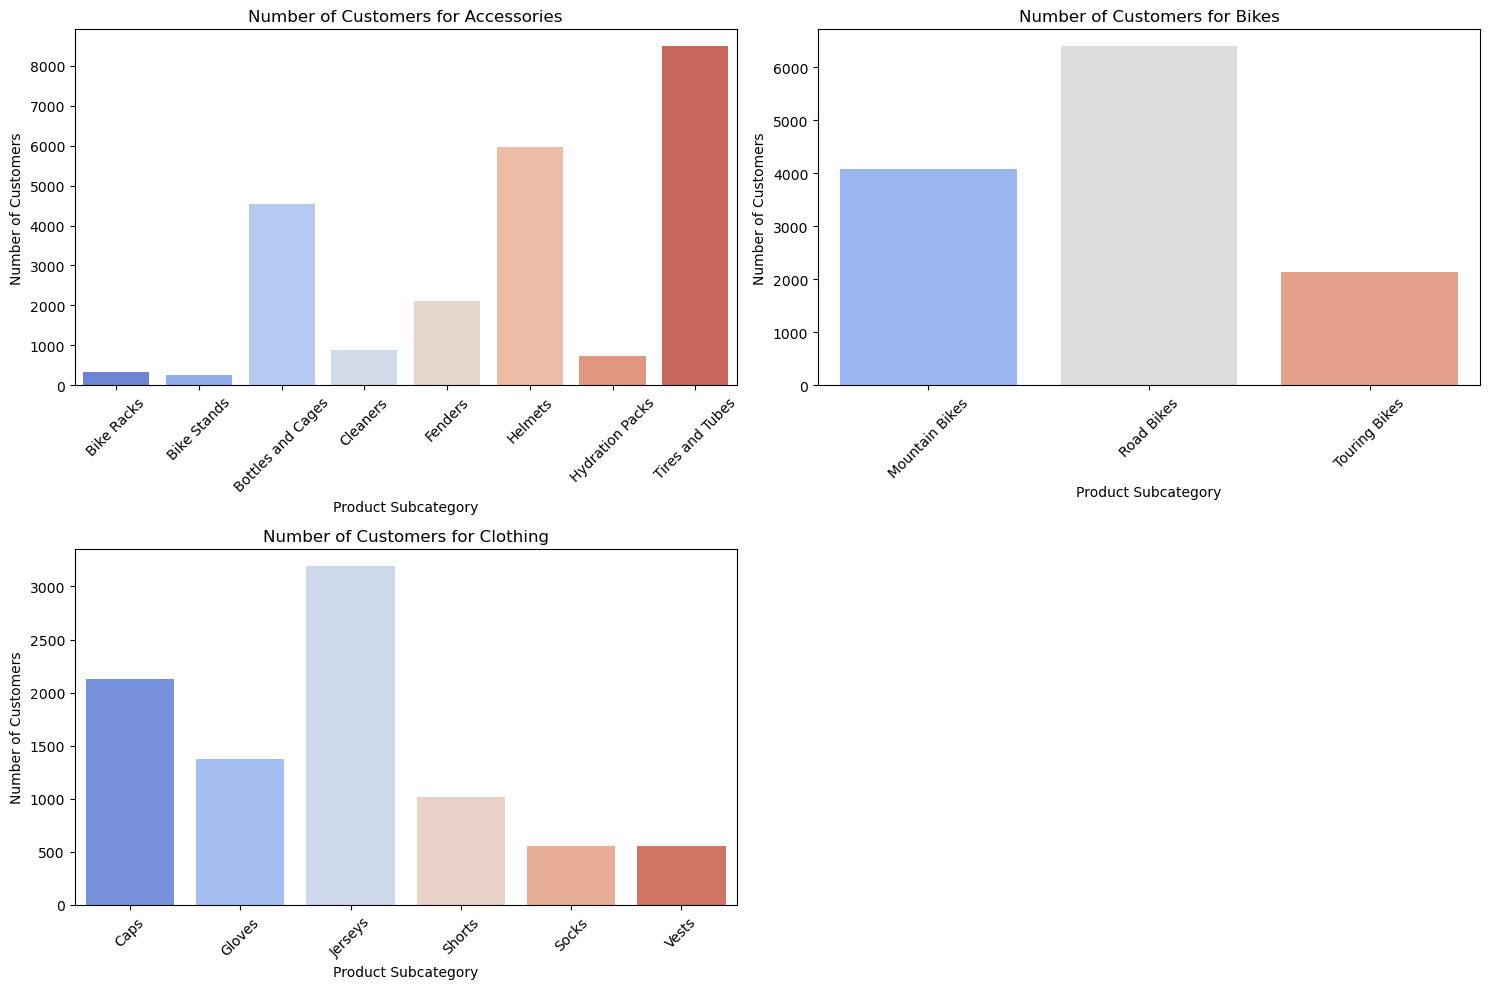

In [22]:
# Relationship between the customers and their interest in products 
customer_subcategory = df.groupby(['Product Category', 'Product Subcategory'])['CustomerID'].nunique().reset_index()

# Get unique product categories
product_categories = customer_subcategory['Product Category'].unique()

# Plotting
plt.figure(figsize=(15, 10))

for i, category in enumerate(product_categories, start=1):
    plt.subplot(2, 2, i)
    subset_data = customer_subcategory[customer_subcategory['Product Category'] == category]
    sns.barplot(x='Product Subcategory', y='CustomerID', data=subset_data, palette='coolwarm')
    plt.xlabel('Product Subcategory')
    plt.ylabel('Number of Customers')
    plt.title(f'Number of Customers for {category}')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

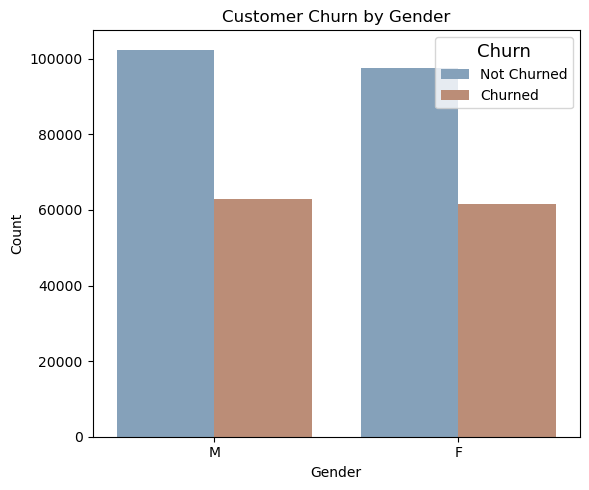

In [23]:
# Relationship between Gender and Customer churn 

plt.figure(figsize=(6, 5))
sns.countplot(x='Gender', 
              hue='CustomerChurn', 
              data=df, 
              palette='twilight_shifted')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Customer Churn by Gender')
plt.legend(title='Churn', title_fontsize='13', labels=['Not Churned', 'Churned'])
plt.tight_layout()
plt.show()

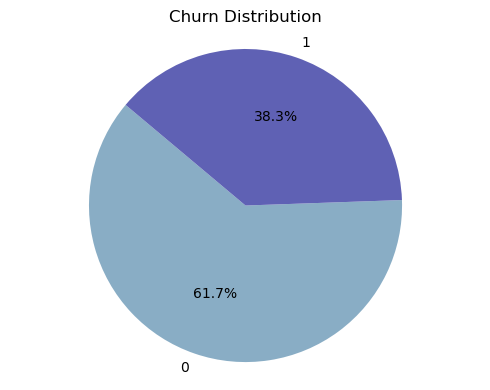

In [24]:
# Calculate the count of churned and non-churned customers
churn_counts = df['CustomerChurn'].value_counts()

# Plotting
plt.figure(figsize=(5, 4))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', colors=sns.color_palette('twilight'), startangle=140)
plt.title('Churn Distribution')
plt.axis('equal')
plt.tight_layout()
plt.show()

## Feature Engineering

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324320 entries, 0 to 324319
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   CustomerID            324320 non-null  category      
 1   ProductID             324320 non-null  category      
 2   Product Category      324320 non-null  object        
 3   Product Subcategory   324320 non-null  object        
 4   SalesOrderID          324320 non-null  category      
 5   OrderQty              324320 non-null  int64         
 6   OrderDate             324320 non-null  datetime64[ns]
 7   ShipDate              324320 non-null  datetime64[ns]
 8   UnitPrice             324320 non-null  float64       
 9   TotalDue              324320 non-null  float64       
 10  LineTotal             324320 non-null  float64       
 11  region                324320 non-null  object        
 12  BirthDate             324320 non-null  datetime64[ns]
 13 

In [27]:
# Drop unnecessary columns 

dataset = df[['region', 'MaritalStatus', 'YearlyIncome', 'Gender', 'NumberChildrenAtHome', 
              'TotalChildren', 'Education', 'Occupation', 'HouseOwnerFlag', 'NumberCarsOwned', 
             'Age', 'Recency', 'Frequency', 'Monetary', 'CustomerChurn']]

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324320 entries, 0 to 324319
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   region                324320 non-null  object 
 1   MaritalStatus         324320 non-null  object 
 2   YearlyIncome          324320 non-null  float64
 3   Gender                324320 non-null  object 
 4   NumberChildrenAtHome  324320 non-null  int64  
 5   TotalChildren         324320 non-null  int64  
 6   Education             324320 non-null  object 
 7   Occupation            324320 non-null  object 
 8   HouseOwnerFlag        324320 non-null  object 
 9   NumberCarsOwned       324320 non-null  int64  
 10  Age                   324320 non-null  int64  
 11  Recency               324320 non-null  int64  
 12  Frequency             324320 non-null  int64  
 13  Monetary              324320 non-null  float64
 14  CustomerChurn         324320 non-null  int32  
dtype

In [28]:
# Viewing the Object dtypes

object_dtype = []

for column in dataset.columns:
    if dataset[column].dtype == 'object':
        num_unique = dataset[column].nunique()
        if num_unique < 20:
            print(f"{column} has {dataset[column].unique()}\n")
        else:
            print(f"There are more than 10 unique values in column '{column}'")

region has ['Canada' 'France' 'Northwest' 'Southwest' 'Australia' 'United Kingdom'
 'Germany' 'Southeast' 'Northeast' 'Central']

MaritalStatus has ['S' 'M']

Gender has ['M' 'F']

Education has ['Bachelors' 'High School' 'Graduate Degree' 'Partial College'
 'Partial High School']

Occupation has ['Management' 'Manual' 'Professional' 'Skilled Manual' 'Clerical']

HouseOwnerFlag has ['1' '0']



In [29]:
# Handling the first encoding, using the onehotencoding

def dummy_encoder(dataset, *columns, **kwargs):
    info = dataset[list(columns)]
    done = pd.get_dummies(info, drop_first=True, **kwargs)
    return done

dummy_encoder = dummy_encoder(dataset, 'MaritalStatus', 'Gender', 'HouseOwnerFlag', 'region')

dummy_encoder.head()

,MaritalStatus_S,Gender_M,HouseOwnerFlag_1,region_Canada,region_Central,region_France,region_Germany,region_Northeast,region_Northwest,region_Southeast,region_Southwest,region_United Kingdom
0,1,1,1,1,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,0,0


In [30]:
# Concatenate the encoded dataset

dataset = pd.concat([dataset, dummy_encoder], axis=1)

dataset = dataset.drop(columns=['MaritalStatus', 'Gender', 'HouseOwnerFlag', 'region'], axis=1)

dataset.head()

,YearlyIncome,NumberChildrenAtHome,TotalChildren,Education,Occupation,NumberCarsOwned,Age,Recency,Frequency,Monetary,...,HouseOwnerFlag_1,region_Canada,region_Central,region_France,region_Germany,region_Northeast,region_Northwest,region_Southeast,region_Southwest,region_United Kingdom
0,70000.0,0,5,Bachelors,Management,3,59,289,4,8236.52,...,1,1,0,0,0,0,0,0,0,0
1,70000.0,0,5,Bachelors,Management,3,61,289,4,8236.52,...,1,1,0,0,0,0,0,0,0,0
2,70000.0,0,5,Bachelors,Management,3,59,289,4,8236.52,...,1,1,0,0,0,0,0,0,0,0
3,70000.0,0,5,Bachelors,Management,3,61,289,4,8236.52,...,1,1,0,0,0,0,0,0,0,0
4,20000.0,3,3,High School,Manual,0,40,1126,1,3399.99,...,0,0,0,1,0,0,0,0,0,0


In [31]:
# Using label encoder to fit transform the dataset

edu_encode = {
    'Partial High School': 1,
    'High School': 2,
    'Partial College': 3,
    'Bachelors': 4,
    'Graduate Degree': 5,
}

occ_encode = {
    'Manual': 1,
    'Skilled Manual': 2,
    'Clerical': 3,
    'Professional': 4,
    'Management': 5,
}

le = LabelEncoder()

dataset['Education'] = le.fit_transform(df['Education'].map(edu_encode))
dataset['Occupation'] = le.fit_transform(df['Occupation'].map(occ_encode))
dataset.head()

,YearlyIncome,NumberChildrenAtHome,TotalChildren,Education,Occupation,NumberCarsOwned,Age,Recency,Frequency,Monetary,...,HouseOwnerFlag_1,region_Canada,region_Central,region_France,region_Germany,region_Northeast,region_Northwest,region_Southeast,region_Southwest,region_United Kingdom
0,70000.0,0,5,3,4,3,59,289,4,8236.52,...,1,1,0,0,0,0,0,0,0,0
1,70000.0,0,5,3,4,3,61,289,4,8236.52,...,1,1,0,0,0,0,0,0,0,0
2,70000.0,0,5,3,4,3,59,289,4,8236.52,...,1,1,0,0,0,0,0,0,0,0
3,70000.0,0,5,3,4,3,61,289,4,8236.52,...,1,1,0,0,0,0,0,0,0,0
4,20000.0,3,3,1,0,0,40,1126,1,3399.99,...,0,0,0,1,0,0,0,0,0,0


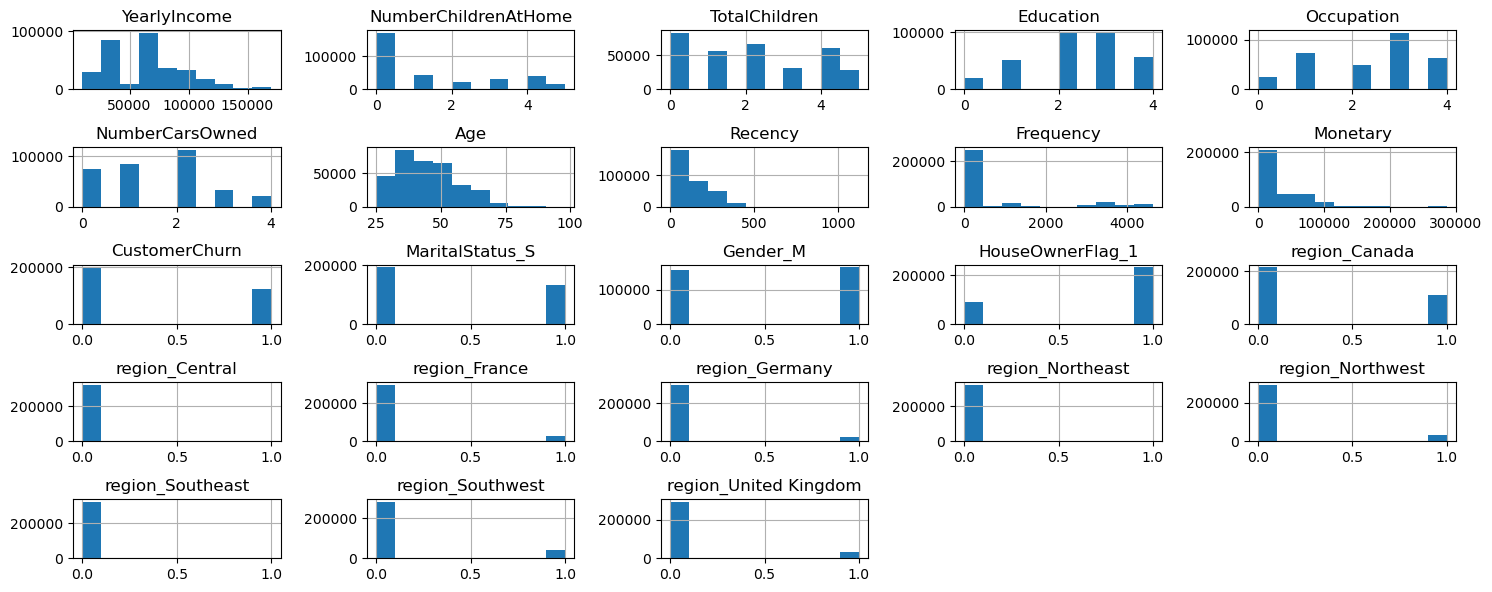

In [34]:
dataset.hist(figsize=(15, 6))
plt.tight_layout(pad=1.0) 
plt.show()

In [35]:
# Using the Standard Scaler to scale a dataset

ss = StandardScaler()

dataset['YearlyIncome'] = ss.fit_transform(dataset[['YearlyIncome']])
dataset['Age'] = ss.fit_transform(dataset[['Age']])
dataset['NumberChildrenAtHome'] = ss.fit_transform(dataset[['NumberChildrenAtHome']])
dataset['TotalChildren'] = ss.fit_transform(dataset[['TotalChildren']])
dataset['Education'] = ss.fit_transform(dataset[['Education']])
dataset['NumberCarsOwned'] = ss.fit_transform(dataset[['NumberCarsOwned']])
dataset['Recency'] = ss.fit_transform(dataset[['Recency']])
dataset['Frequency'] = ss.fit_transform(dataset[['Recency']])
dataset['Monetary'] = ss.fit_transform(dataset[['Recency']])
dataset.head()

,YearlyIncome,NumberChildrenAtHome,TotalChildren,Education,Occupation,NumberCarsOwned,Age,Recency,Frequency,Monetary,...,HouseOwnerFlag_1,region_Canada,region_Central,region_France,region_Germany,region_Northeast,region_Northwest,region_Southeast,region_Southwest,region_United Kingdom
0,0.198659,-0.777819,1.763753,0.558206,4,1.313096,1.313690,1.553109,1.553109,1.553109,...,1,1,0,0,0,0,0,0,0,0
1,0.198659,-0.777819,1.763753,0.558206,4,1.313096,1.494003,1.553109,1.553109,1.553109,...,1,1,0,0,0,0,0,0,0,0
2,0.198659,-0.777819,1.763753,0.558206,4,1.313096,1.313690,1.553109,1.553109,1.553109,...,1,1,0,0,0,0,0,0,0,0
3,0.198659,-0.777819,1.763753,0.558206,4,1.313096,1.494003,1.553109,1.553109,1.553109,...,1,1,0,0,0,0,0,0,0,0
4,-1.384201,1.007565,0.570464,-1.215436,0,-1.332664,-0.399276,9.306110,9.306110,9.306110,...,0,0,0,1,0,0,0,0,0,0


### Machine Learning for Classification

In [36]:
# Libraries for machine classification 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, auc, roc_curve

In [39]:
# Split the dataset into X and y

X = dataset.iloc[:, [i for i in range(len(dataset.columns)) if i != 10]]
y = dataset.iloc[:, 10]

print(X.columns)
print('\n')
print(y.name)


Index(['YearlyIncome', 'NumberChildrenAtHome', 'TotalChildren', 'Education',
       'Occupation', 'NumberCarsOwned', 'Age', 'Recency', 'Frequency',
       'Monetary', 'MaritalStatus_S', 'Gender_M', 'HouseOwnerFlag_1',
       'region_Canada', 'region_Central', 'region_France', 'region_Germany',
       'region_Northeast', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'region_United Kingdom'],
      dtype='object')


CustomerChurn


In [40]:
# Split data into training and testing sets (adjust test_size as needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training is complete')

Training is complete


#### Random Forest Classifier Performance

In [41]:
# Initialising the Model

RFC = RandomForestClassifier(n_estimators=100, random_state=42)
RFC.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [42]:
# Predict probabilities for positive class

y_probs = RFC.predict_proba(X_test)[:, 1]

y_pred = RFC.predict(X_test)

print(y_probs)
print(y_pred)

[1. 0. 0. ... 0. 0. 1.]
[1 0 0 ... 0 0 1]


In [43]:
# Evaluate RFC model performance

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1-score:", round(f1, 3))

Accuracy: 0.915
Precision: 0.901
Recall: 0.875
F1-score: 0.888


In [44]:
# Generate confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[37569,  2393],
       [ 3121, 21781]], dtype=int64)

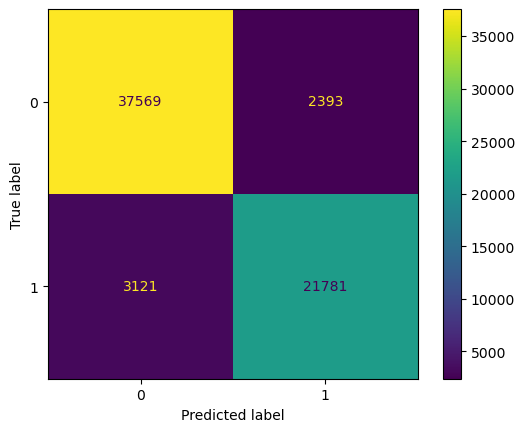

In [45]:
# Plot confusion matrix

plot_confusion_matrix(RFC, X_test, y_test)
plt.show()

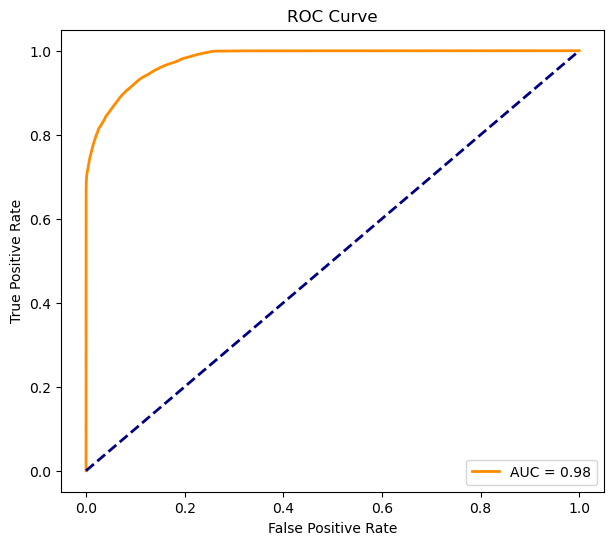

In [46]:
# Compute ROC curve and ROC area

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

#### Customer Segmentation using their RFM Score

In [47]:
# Importing our K means Library

from sklearn.cluster import KMeans

In [60]:
# Using our calculated RFM score to create our customer churn

cluster_x = df.iloc[:, [24, 25, 26]].values

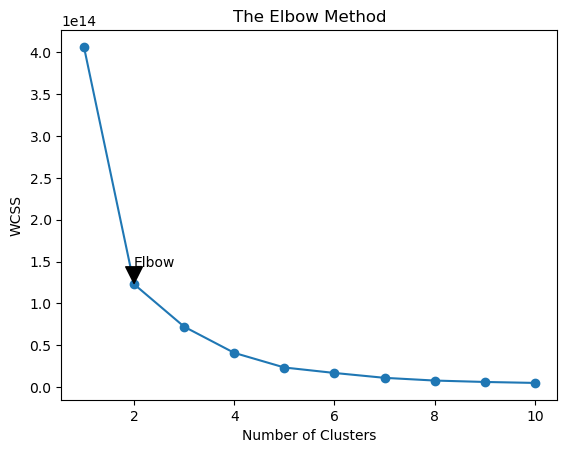

In [61]:
# Elbow method with marker difference

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(cluster_x)
    wcss.append(kmeans.inertia_)

# Calculate the differences between consecutive WCSS values
differences = np.diff(wcss)

# Calculate the second differences
second_differences = np.diff(differences)

# Find the index where the second difference is maximum
elbow_index = np.where(second_differences == max(second_differences))[0][0] + 1

# Plot the Elbow Method with markers at the elbows
plt.plot(range(1, 11), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

# Add marker for the elbow point
plt.annotate('Elbow',
             xy=(elbow_index + 1, wcss[elbow_index]),
             xytext=(elbow_index + 1, wcss[elbow_index] + max(wcss) * 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()


In [62]:
# Training the K-Means model on the dataset
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(cluster_x)


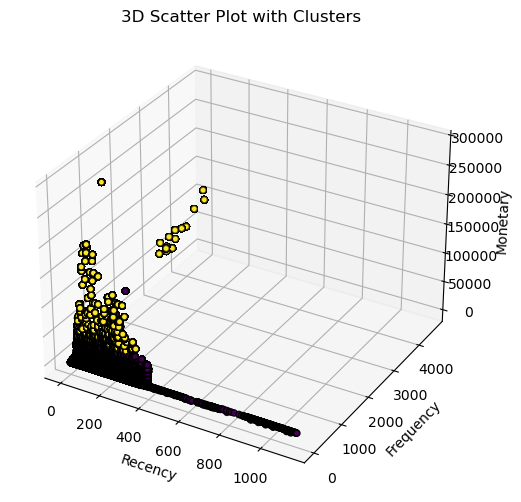

In [70]:
# 3D plot representing the clusters in the RFM

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(cluster_x[:, 0], cluster_x[:, 1], cluster_x[:, 2], c=y_kmeans, cmap='viridis', edgecolor='k')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Scatter Plot with Clusters')
plt.show()

In [77]:
# Creating the cluster label

dataset['cluster'] = (kmeans.labels_ +1)
cluster_labels = {2: 'Low RFM', 1: 'High RFM'}
df['Cluster_label'] = dataset['cluster'].map(cluster_labels)
print('Successful')

Successful


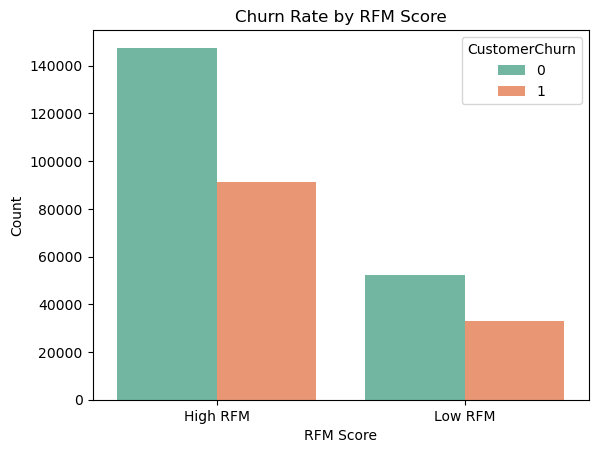

In [76]:
# Representation of result

sns.countplot(x='Cluster_label', hue='CustomerChurn', data=df, palette='Set2')
plt.title('Churn Rate by RFM Score')
plt.xlabel('RFM Score')
plt.ylabel('Count')
plt.show()

In [82]:
# Calculate percentages for each group

grouped = df.groupby(['Cluster_label', 'CustomerChurn']).size().unstack()
grouped['Total'] = grouped.sum(axis=1)
grouped['Churn_Percent'] = grouped[1] / grouped['Total']
grouped['Non_Churn_Percent'] = grouped[0] / grouped['Total']

Text(0.5, 1.0, 'Non-Churn Customers')

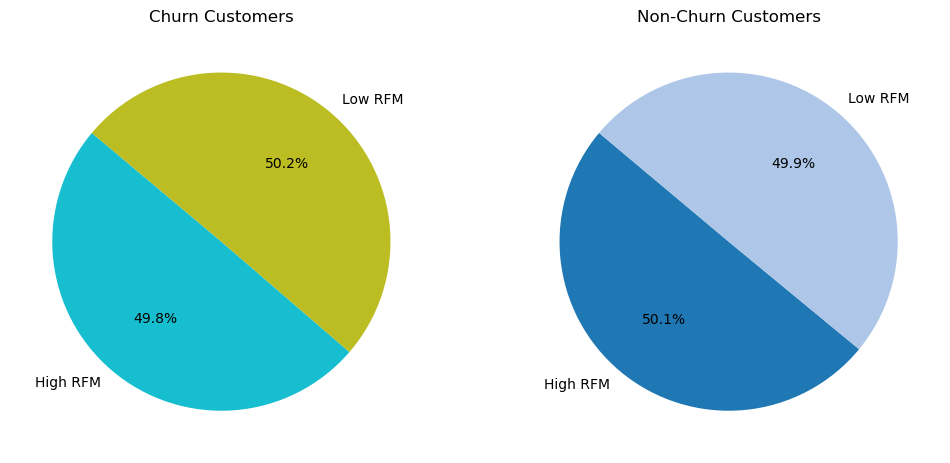

In [89]:
# Plotting Pie Charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for Churn Customers
axes[0].pie(grouped['Churn_Percent'], labels=grouped.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10_r.colors)
axes[0].set_title('Churn Customers')

# Pie chart for Non-Churn Customers
axes[1].pie(grouped['Non_Churn_Percent'], labels=grouped.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
axes[1].set_title('Non-Churn Customers')